In [1]:
import os
import json,cv2
import pandas as pd
import numpy as np
import torch,torchvision
import wandb
from torch.nn import *
from torch.optim import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.models import *

In [2]:
import wandb
device = 'cuda'
PROJECT_NAME = 'Car-Object-Detection-V1-Learning-Object-Detection'

In [3]:
torch.__version__,torchvision.__version__,wandb.__version__,json.__version__,pd.__version__,np.__version__

('1.9.1+cu111', '0.10.1+cu111', '0.12.1', '2.0.9', '1.3.3', '1.20.3')

In [4]:
data = pd.read_csv('./data.csv').sample(frac=1)

In [5]:
data

,image,xmin,ymin,xmax,ymax
142,vid_4_17140.jpg,544.908828,174.808559,657.412446,229.094273
289,vid_4_22980.jpg,536.104197,182.144466,656.434153,225.181789
518,vid_4_9420.jpg,424.900218,174.694786,532.725419,219.487532
12,vid_4_10520.jpg,0.000000,195.349099,36.685962,234.473938
359,vid_4_28860.jpg,80.219971,193.392857,168.266281,231.539575
...,...,...,...,...,...
255,vid_4_2140.jpg,464.199711,180.188224,659.858177,251.591055
417,vid_4_6180.jpg,425.068017,177.253861,559.094067,225.181789
110,vid_4_14400.jpg,0.000000,190.947555,55.273517,228.116152
231,vid_4_2060.jpg,491.591896,184.589768,597.736614,222.736487


In [6]:
img = cv2.imread('./data/vid_4_12300.jpg')

In [7]:
xmin,ymin,xmax,ymax = 386,185,554,230

In [8]:
x = xmin
y = ymin
w = xmax - xmin
h = ymax - ymin

In [9]:
crop = img[y:y+h,x:x+w]

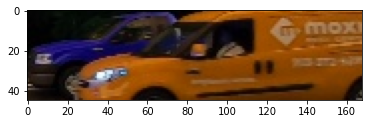

In [10]:
plt.imshow(crop)

In [11]:
cv2.imwrite('./crop.png',crop)

True

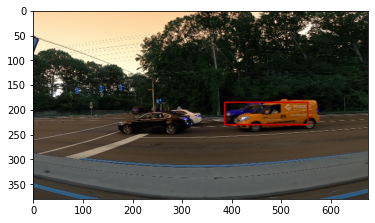

In [12]:
plt.imshow(cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2))

In [13]:
cv2.imwrite('./box.png',cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2))

True

In [14]:
def load_data():
    new_data = []
    for idx in tqdm(range(len(data)):)
        new_data_iter = []
        info = data.iloc[idx]
        new_data.append([
            cv2.resize(cv2.imread(f'./data/{info["image"]}'),(112,112))/255.0,
            [info['xmin'],info['ymin'],info['xmax'],info['ymax']]
        ])
    X = []
    y = []
    for d in new_data:
        X.append(d[0])
        y.append(d[1])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,shuffle=False)
    X_train = torch.from_numpy(np.array(X_train)).to(device).view(-1,3,56,56).float()
    y_train = torch.from_numpy(np.array(y_train)).to(device).float()
    X_test = torch.from_numpy(np.array(X_test)).to(device).view(-1,3,56,56).float()
    y_test = torch.from_numpy(np.array(y_test)).to(device).float()
    return X,y,X_train,X_test,y_train,y_test,new_data

In [15]:
X,y,X_train,X_test,y_train,y_test,new_data = load_data()

In [16]:
torch.save(X_train,'X_train.pt')
torch.save(y_train,'y_train.pt')
torch.save(X_test,'X_test.pt')
torch.save(y_test,'y_test.pt')
torch.save(X_train,'X_train.pth')
torch.save(y_train,'y_train.pth')
torch.save(X_test,'X_test.pth')
torch.save(y_test,'y_test.pth')

In [17]:
def get_loss(model,X,y,criterion):
    preds = model(X)
    loss = criterion(preds,y)
    return loss.item()

In [18]:
def get_accuracy(model,X,y):
    preds = model(X)
    correct = 0
    total = 0
    for pred,yb in zip(preds,y):
        pred = int(torch.argmax(pred))
        yb = int(torch.argmax(yb))
        if pred == yb:
            correct += 1
        total += 1
    acc = round(correct/total,3)*100
    return acc

In [19]:
model = resnet18(pretrained=True).to(device)
model.fc = Linear(512,4)
criterion = MSELoss()
optimizer = Adam(model.parameters(),lr=0.001)
epochs = 100
batch_size = 32

In [24]:
wandb.init(project=PROJECT_NAME,name='baseline-TL-True')
for _ in tqdm(range(epochs)):
    for i in range(0,len(X_train),batch_size):
        try:
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            model.to(device)
            preds = model(X_batch)
            loss = criterion(preds,y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        except:
            pass
    model.eval()
    torch.cuda.empty_cache()
    wandb.log({'Loss':(get_loss(model,X_train,y_train,criterion)+get_loss(model,X_batch,y_batch,criterion))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val Loss':get_loss(model,X_test,y_test,criterion)})
    torch.cuda.empty_cache()
    wandb.log({'Acc':(get_accuracy(model,X_train,y_train)+get_accuracy(model,X_batch,y_batch))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val ACC':get_accuracy(model,X_test,y_test)})
    torch.cuda.empty_cache()
    model.train()
wandb.finish()

wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/indika/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([0, 4])) that is different to the input size (torch.Size([32, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/indika/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([0, 4])) that is different to the input size (torch.Size([28, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                   | 0/100 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.77 GiB total capacity; 1.78 GiB already allocated; 45.19 MiB free; 1.82 GiB reserved in total by PyTorch)

In [ ]:
y_batch.shape,preds.shape

In [ ]:
model = resnet18(pretrained=False).to(device)
model.fc = Linear(512,4)
criterion = MSELoss()
optimizer = Adam(model.parameters(),lr=0.001)
epochs = 100
batch_size = 32

In [ ]:
wandb.init(project=PROJECT_NAME,name='baseline-TL-False')
for _ in tqdm(range(epochs)):
    for i in range(0,len(X_train),batch_size):
        try:
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            model.to(device)
            preds = model(X_batch)
            loss = criterion(preds,y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        except:
            pass
    model.eval()
    torch.cuda.empty_cache()
    wandb.log({'Loss':(get_loss(model,X_train,y_train,criterion)+get_loss(model,X_batch,y_batch,criterion))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val Loss':get_loss(model,X_test,y_test,criterion)})
    torch.cuda.empty_cache()
    wandb.log({'Acc':(get_accuracy(model,X_train,y_train)+get_accuracy(model,X_batch,y_batch))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val ACC':get_accuracy(model,X_test,y_test)})
    torch.cuda.empty_cache()
    model.train()
wandb.finish()

In [26]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.activation = ReLU()
        self.conv1 = Conv2d(3,7,(5,5))
        self.conv2 = Conv2d(7,14,(5,5))
        self.conv2bn = BatchNorm2d(14)
        self.conv3 = Conv2d(14,21,(5,5))
        self.linear1 = Linear(21*3*3,256)
        self.linear2 = Linear(256,512)
        self.linear2bn = BatchNorm1d(512)
        self.linear3 = Linear(512,256)
        self.output = Linear(256,4)
        
    def forward(self,X):
        preds = self.max_pool2d(self.activation(self.conv1(X)))
        preds = self.max_pool2d(self.activation(self.conv2bn(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3(preds)))
        preds = preds.view(-1,21*3*3)
        preds = self.activation(self.linear1(preds))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.activation(self.linear3(preds))
        preds = self.output(preds)
        return preds

In [27]:
model = Model().to(device)
criterion = MSELoss()
optimizer = Adam(model.parameters(),lr=0.001)
epochs = 100
batch_size = 32

NameError: name 'labels' is not defined

In [ ]:
wandb.init(project=PROJECT_NAME,name='baseline-CNN')
for _ in tqdm(range(epochs)):
    for i in range(0,len(X_train),batch_size):
        try:
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            model.to(device)
            preds = model(X_batch)
            loss = criterion(preds,y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        except:
            pass
    model.eval()
    torch.cuda.empty_cache()
    wandb.log({'Loss':(get_loss(model,X_train,y_train,criterion)+get_loss(model,X_batch,y_batch,criterion))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val Loss':get_loss(model,X_test,y_test,criterion)})
    torch.cuda.empty_cache()
    wandb.log({'Acc':(get_accuracy(model,X_train,y_train)+get_accuracy(model,X_batch,y_batch))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val ACC':get_accuracy(model,X_test,y_test)})
    torch.cuda.empty_cache()
    model.train()
wandb.finish()

wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
